<a href="https://colab.research.google.com/github/AnonyBOSS/detect-AI/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

detect_ai_vs_human_generated_images_path = kagglehub.competition_download('detect-ai-vs-human-generated-images')
alessandrasala79_ai_vs_human_generated_dataset_path = kagglehub.dataset_download('alessandrasala79/ai-vs-human-generated-dataset')

print('Data source import complete.')


## Detect AI images

$Today$ rapidly evolving digital world, AI-generated content has become more sophisticated and widespread. This includes deep-fake videos, fake news, and generative art. It is becoming increasingly difficult to distinguish between what is real and what is created by AI. This challenge has significant implications for media, security, and creativity.


![images.jpg](attachment:9b43d768-ee5e-4648-956b-9225827705b7.jpg)

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt



In [ ]:

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
batch_size = 64
epochs = 10 # beacuse we cannot exeed time 12h
lr = 0.023276939100527697
gamma = 0.000709264311831273

residual_dropout = 0.18512537739519747

seed_everything(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used :", device)

Device used : cuda


In [ ]:
# Paths to the dataset
base_dir = '/kaggle/input/ai-vs-human-generated-dataset'
train_csv_path = os.path.join(base_dir, 'train.csv')
test_csv_path  = os.path.join(base_dir, 'test.csv')

# Reading the training CSV file
df_train = pd.read_csv(train_csv_path)
# Example of a row: file_name="train_data/041be3153810...", label=0 or 1

# Reading the testing CSV file
df_test = pd.read_csv(os.path.join(base_dir, 'test.csv'))
# Exemple: df_test['id'] = "test_data_v2/e25323c62af644fba97afb846261b05b.jpg", etc.

# Adding the full path to the file_name instead of just "trainORtest_data/xxx.jpg"
df_test['id'] = df_test['id'].apply(lambda x: os.path.join(base_dir, x))
df_train['file_name'] = df_train['file_name'].apply(lambda x: os.path.join(base_dir, x))

all_image_paths = df_train['file_name'].values
all_labels = df_train['label'].values

# Splitting train/validation (95% / 5%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=0.05,
    random_state=seed,
    shuffle=False
)


print(f"Train Data: {len(train_paths)}")
print(f"Validation Data: {len(val_paths)}")

Train Data: 75952
Validation Data: 3998


# Augmentation


In [ ]:
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

train_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(20),
    T.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

test_transforms = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, file_list, labels=None, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            label = self.labels[idx]
            return img, label
        else:
            return img

class TestImageDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)

# DataLoader

Shuffle the train data, not a test.  

In [ ]:
train_data = ImageDataset(train_paths, train_labels, transform=train_transforms)
val_data   = ImageDataset(val_paths,   val_labels,   transform=val_transforms)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(dataset=val_data,   batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train Dataset size: {len(train_data)}")
print(f"Validation Dataset size: {len(val_data)}")



Train Dataset size: 75952
Validation Dataset size: 3998


In [ ]:
model = models.efficientnet_v2_m(weights="EfficientNet_V2_M_Weights.DEFAULT")

# Freeze all layers initially
#for param in model.parameters():
#    param.requires_grad = False

#block4_section1 = getattr(model.trunk_output.block4, 'block4-1')
#block4_section1.requires_grad_(True)
# Freeze most of the model parameters but unfreeze some layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the last few layers of the features
for param in model.features[-5:].parameters():
    param.requires_grad = True



model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(in_features=1280, out_features=256, bias=True),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=2, bias=True)
    ).to(device)

model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:00<00:00, 228MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

# Training the model

In [ ]:
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1s = []

In [ ]:
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for data, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = output.argmax(dim=1)
        acc = (preds == label).float().mean().item()
        epoch_accuracy += acc

    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # -- Validation --
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_pred_classes = []
    val_labels_list = []

    with torch.no_grad():
        for data, label in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            data, label = data.to(device), label.to(device)
            output = model(data)

            loss = criterion(output, label)
            val_loss += loss.item()

            preds = output.argmax(dim=1)
            acc = (preds == label).float().mean().item()
            val_acc += acc

            val_pred_classes.extend(preds.cpu().numpy())
            val_labels_list.extend(label.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    val_f1 = f1_score(val_labels_list, val_pred_classes)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
    )

    scheduler.step()



Validation Epoch 1: 100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


Epoch [1/10] Train Loss: 0.3447 | Train Acc: 0.8251 | Val Loss: 0.2695 | Val Acc: 0.9026 | Val F1: 0.8947


Validation Epoch 2: 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


Epoch [2/10] Train Loss: 0.2128 | Train Acc: 0.9135 | Val Loss: 0.1484 | Val Acc: 0.9458 | Val F1: 0.9482


Validation Epoch 3: 100%|██████████| 63/63 [00:19<00:00,  3.21it/s]


Epoch [3/10] Train Loss: 0.2038 | Train Acc: 0.9182 | Val Loss: 0.1406 | Val Acc: 0.9460 | Val F1: 0.9484


Validation Epoch 4: 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


Epoch [4/10] Train Loss: 0.2070 | Train Acc: 0.9167 | Val Loss: 0.1467 | Val Acc: 0.9433 | Val F1: 0.9461


Validation Epoch 5: 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


Epoch [5/10] Train Loss: 0.2054 | Train Acc: 0.9179 | Val Loss: 0.1453 | Val Acc: 0.9483 | Val F1: 0.9505


Validation Epoch 6: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]


Epoch [6/10] Train Loss: 0.2083 | Train Acc: 0.9157 | Val Loss: 0.1412 | Val Acc: 0.9458 | Val F1: 0.9483


Validation Epoch 7: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]


Epoch [7/10] Train Loss: 0.2047 | Train Acc: 0.9177 | Val Loss: 0.1531 | Val Acc: 0.9446 | Val F1: 0.9471


Validation Epoch 8: 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


Epoch [8/10] Train Loss: 0.2041 | Train Acc: 0.9180 | Val Loss: 0.1442 | Val Acc: 0.9456 | Val F1: 0.9480


Validation Epoch 9: 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


Epoch [9/10] Train Loss: 0.2060 | Train Acc: 0.9174 | Val Loss: 0.1451 | Val Acc: 0.9473 | Val F1: 0.9496


Validation Epoch 10: 100%|██████████| 63/63 [00:19<00:00,  3.19it/s]

Epoch [10/10] Train Loss: 0.2051 | Train Acc: 0.9179 | Val Loss: 0.1515 | Val Acc: 0.9421 | Val F1: 0.9449


# Loss and accuracy

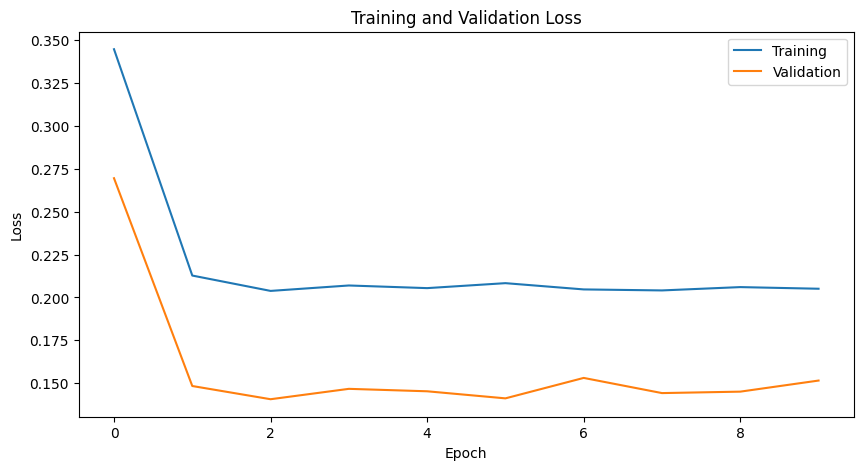

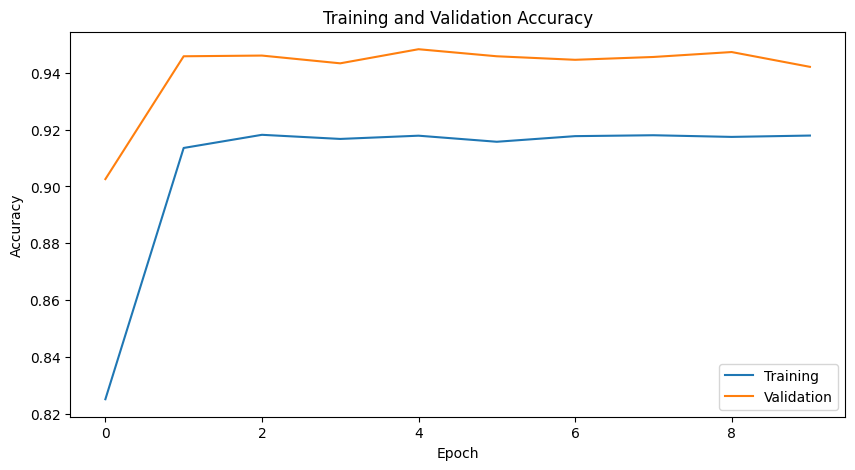

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Training")
plt.plot(val_accuracies, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [ ]:
test_dataset = TestImageDataset(df_test['id'].values, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model.eval()
predictions = []
image_names = []

with torch.no_grad():
    for data, names in tqdm(test_loader, desc="Predicting"):
        data = data.to(device)
        outputs = model(data)

        # predict
        preds = outputs.argmax(dim=1)  # shape [batch_size]

        predictions.extend(preds.cpu().numpy())
        image_names.extend([f"test_data_v2/{name}" for name in names])



Predicting: 100%|██████████| 87/87 [01:22<00:00,  1.05it/s]


In [ ]:
submission_df = pd.DataFrame({
    'id': image_names,
    'label': predictions
})

In [ ]:
submission_df.head()

,id,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,1
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,1
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,0
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,0
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,0


In [ ]:
submission_df.to_csv("submit.csv", index=False)
print("Submission file generated: submit.csv")

Submission file generated: submit.csv
